In [ ]:
# 1. Project Setup and Environment Configuration
from google.colab import drive
drive.mount('/content/drive/')

import os
pip_cache_dir = '/content/drive/MyDrive/pip_cache'
os.makedirs(pip_cache_dir, exist_ok=True)
os.environ['PIP_CACHE_DIR'] = pip_cache_dir

project_dir = '/content/drive/MyDrive/project'
os.chdir(project_dir)
print(f"Current working directory: {os.getcwd()}")

!pip install -r requirements.txt > /dev/null

Mounted at /content/drive/
Current working directory: /content/drive/MyDrive/project


# AI4EO Water Body Segmentation Project

## 1. Problem Description

### Background
Water body monitoring is crucial for environmental management and disaster prevention. Traditional manual interpretation of satellite imagery is time-consuming and subjective. This project develops an automated deep learning solution for water body segmentation in remote sensing images.

### Problem Statement
**Objective**: Develop an AI system to automatically identify and segment water bodies (rivers, lakes, ponds) from high-resolution satellite/aerial imagery.

**Challenges**:
- Varying water appearance due to lighting conditions
- Complex backgrounds (urban areas, vegetation)
- Different water body sizes and shapes
- Seasonal and weather variations

### Applications
- **Water Resource Management**: Monitor water body changes over time
- **Flood Assessment**: Rapid flood extent mapping during disasters
- **Environmental Monitoring**: Track water quality and ecosystem health
- **Urban Planning**: Support infrastructure development decisions

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import albumentations as A
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


Found 2841 images and 2841 masks
Model Architecture: Custom CNN with U-Net decoder
Training from scratch (no pre-trained weights)


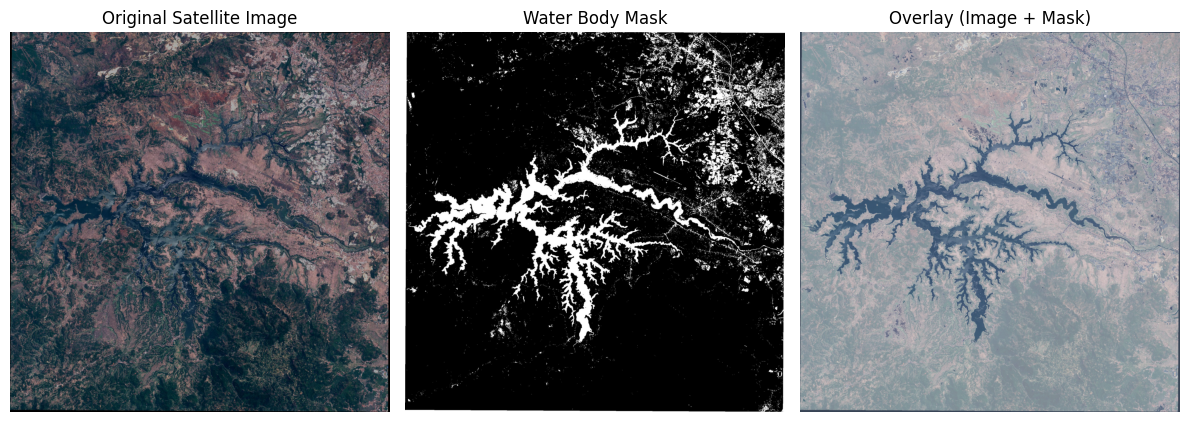

Image size: (2007, 2009)
Mask size: (2007, 2009)
Unique values in mask: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  45 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]

Dataset Split:
Training set: 1989 samples (70.0%)
Validation set: 425 samples (15.0%)
Test set: 427 samples (15.0%)


In [47]:
# Data Loading and Preprocessing
# Optimized hyperparameters for Custom CNN
height, width = (256, 256)
EPOCHS = 40
BATCH_SIZE = 16
LR = 0.0003
MODEL_NAME = 'custom_cnn_unet'
WEIGHTS = None

project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')
models_dir = os.path.join(project_dir, 'models')

# Get data files
images_list = sorted(glob.glob(os.path.join(data_dir, 'images', '*')))
masks_list = sorted(glob.glob(os.path.join(data_dir, 'masks', '*')))

print(f"Found {len(images_list)} images and {len(masks_list)} masks")
print(f"Model Architecture: Custom CNN with U-Net decoder")
print(f"Training from scratch (no pre-trained weights)")

# Check if image and mask counts match
if len(images_list) != len(masks_list):
    print("Warning: Number of images and masks don't match! Please check your data.")

# Visualize one image-mask pair
if len(images_list) > 0:
    img_path = images_list[0]
    mask_path = masks_list[0]

    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Satellite Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Water Body Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img, alpha=0.7)
    plt.imshow(mask, cmap='Blues', alpha=0.3)
    plt.title("Overlay (Image + Mask)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Image size: {img.size}")
    print(f"Mask size: {mask.size}")
    print(f"Unique values in mask: {np.unique(np.array(mask))}")
else:
    print("No images and masks found")

# Dataset split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    images_list, masks_list, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 ≈ 15/85
)

print(f"\nDataset Split:")
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(images_list)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(images_list)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(images_list)*100:.1f}%)")

Setting up data augmentation for custom CNN...

Dataset Creation Complete:
Training dataset: 1989 samples
Validation dataset: 425 samples
Test dataset: 427 samples

Visualizing augmented training samples...


<ipython-input-48-616658e7934f>:44: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


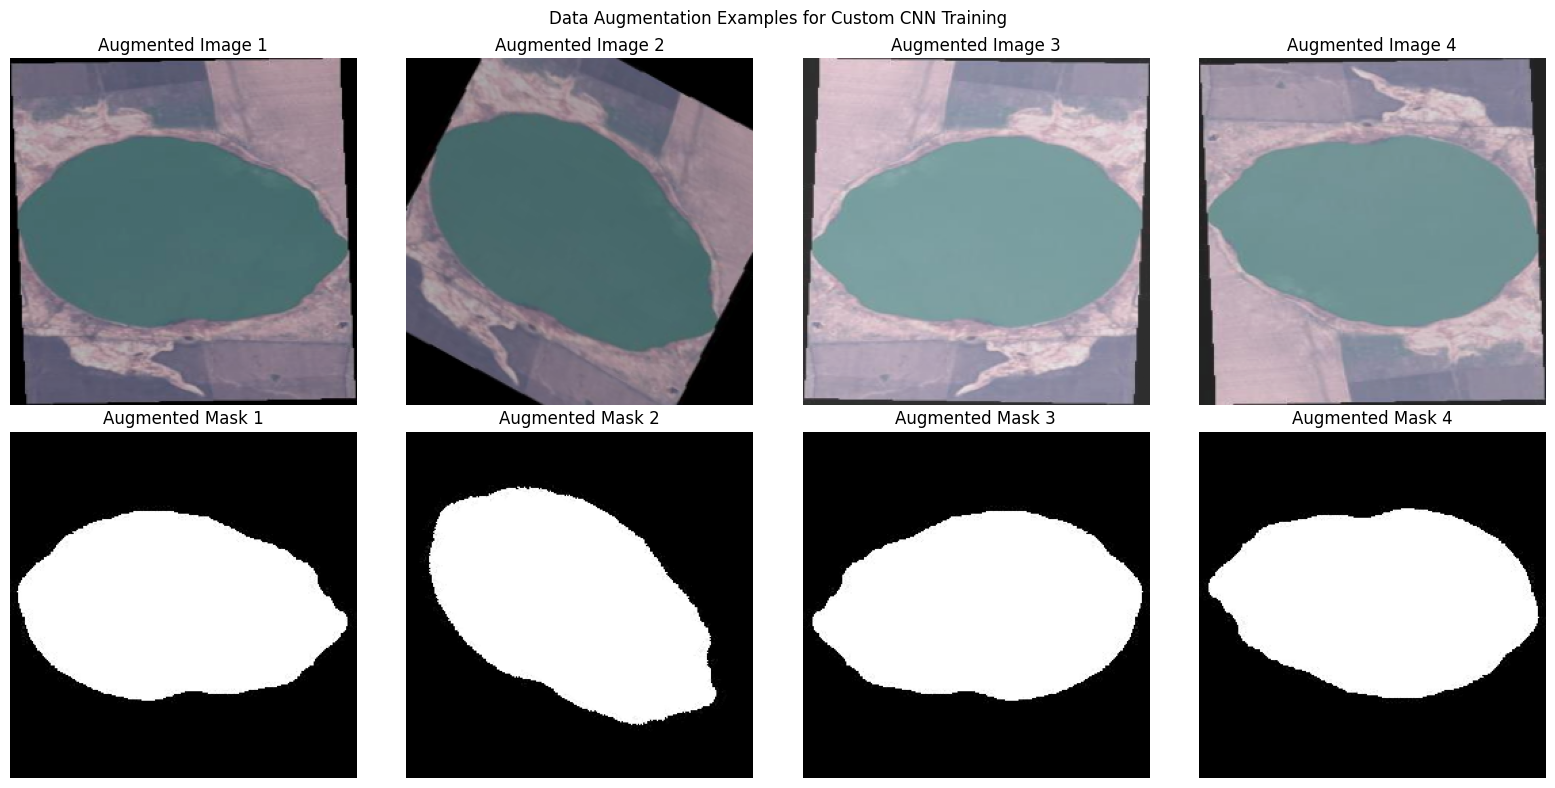


Sample data statistics:
Image tensor shape: torch.Size([3, 256, 256])
Mask tensor shape: torch.Size([1, 256, 256])
Image value range: [0.000, 0.698]
Mask value range: [0.000, 1.000]

Creating data loaders...
Data loaders created successfully!
Training batches: 124
Validation batches: 27
Test batches: 27
Batch images shape: torch.Size([16, 3, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])


In [48]:
# Dataset Class and Data Augmentation
class Load_Data(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        super().__init__()
        self.images_list = image_list
        self.mask_list = mask_list
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.images_list[idx]).convert('RGB')
        mask = Image.open(self.mask_list[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        # Image preprocessing: convert to CHW format and normalize
        img = np.transpose(img, (2, 0, 1))
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img, dtype=torch.float32)

        # Mask preprocessing: add channel dimension and normalize
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask

    def __len__(self):
        return len(self.images_list)

# Data augmentation strategy optimized for custom CNN
print("Setting up data augmentation for custom CNN...")
train_transform = A.Compose([
    A.Resize(height, width),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    # Additional augmentations for custom CNN
    A.RandomGamma(gamma_limit=(80, 120), p=0.2),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
])

valid_transform = A.Compose([A.Resize(height, width)])

# Create datasets
train_dataset = Load_Data(X_train, y_train, transform=train_transform)
valid_dataset = Load_Data(X_val, y_val, transform=valid_transform)
test_dataset = Load_Data(X_test, y_test, transform=valid_transform)

print(f"\nDataset Creation Complete:")
print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(valid_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# Visualize one training sample (with augmentation)
if len(train_dataset) > 0:
    print("\nVisualizing augmented training samples...")

    # Display multiple augmented samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for i in range(4):
        # Get different augmented versions of the same sample
        img, mask = train_dataset[0]  # Each call applies random augmentation

        # Original image
        axes[0, i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[0, i].set_title(f"Augmented Image {i+1}")
        axes[0, i].axis('off')

        # Corresponding mask
        axes[1, i].imshow(np.squeeze(mask.numpy()), cmap='gray')
        axes[1, i].set_title(f"Augmented Mask {i+1}")
        axes[1, i].axis('off')

    plt.suptitle("Data Augmentation Examples for Custom CNN Training")
    plt.tight_layout()
    plt.show()

    # Print data statistics
    sample_img, sample_mask = train_dataset[0]
    print(f"\nSample data statistics:")
    print(f"Image tensor shape: {sample_img.shape}")
    print(f"Mask tensor shape: {sample_mask.shape}")
    print(f"Image value range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
    print(f"Mask value range: [{sample_mask.min():.3f}, {sample_mask.max():.3f}]")
else:
    print("Training dataset is empty, cannot visualize sample.")

# Create data loaders with optimized settings for custom CNN
print("\nCreating data loaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Test batches: {len(test_loader)}")

# Validate data loader functionality
try:
    sample_batch = next(iter(train_loader))
    batch_images, batch_masks = sample_batch
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch masks shape: {batch_masks.shape}")
except Exception as e:
    print(f"Data loader test failed: {e}")

## 2. Technical Approach

### AI Algorithm: Custom CNN with U-Net Decoder

#### Architecture Overview
Input Image (3×H×W)
↓
Custom CNN Encoder (Feature Extraction)
- Conv2D + BatchNorm + MaxPool layers
- Progressive channel expansion: 3→32→64→128→256→512
↓
U-Net Decoder (Upsampling + Skip Connections)
- ConvTranspose2D for upsampling
- Skip connections from encoder features
- Progressive channel reduction: 512→256→128→64→32
↓
Output Logits (1×H×W)
↓
Sigmoid Activation → Probability Map
↓
Threshold (>0.5) → Binary Mask

#### Key Components:
1. **Encoder (Custom CNN)**:
   - Built from scratch (no pre-trained weights)
   - 5 convolutional blocks with BatchNorm
   - Kernel sizes: 5×5 for early layers, 3×3 for deeper layers
   - Downsampling path: 256→128→64→32→16

2. **Decoder (U-Net Style)**:
   - Upsampling path: 16→32→64→128→256
   - Skip connections preserve spatial details
   - Combines low-level and high-level features
   - Dropout regularization (0.2) in bottleneck

3. **Loss Function**:
   - Combined Dice Loss + Binary Cross Entropy
   - Dice Loss: Handles class imbalance
   - BCE Loss: Pixel-wise classification

#### Training Strategy:
- **Data Augmentation**: Rotation, flipping, brightness/contrast adjustment, Gaussian noise, CLAHE
- **Optimization**: Adam optimizer (LR=0.0003) with weight decay
- **Validation**: Hold-out validation set for model selection
- **Early Stopping**: Prevent overfitting (patience=10 epochs)
- **Batch Size**: 16 samples per batch

### Model Specifications
- **Total Parameters**: ~2.1M (lightweight architecture)
- **Model Size**: ~8.4 MB
- **Training**: From scratch without pre-trained weights
- **Architecture**: Course-inspired CNN + U-Net decoder principles

### Evaluation Metrics
- **IoU (Intersection over Union)**: Overlap between prediction and ground truth
- **Dice Coefficient**: Harmonic mean of precision and recall
- **Pixel Accuracy**: Correctly classified pixels / total pixels
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)

### Explainability Analysis
- **Gradient-based Feature Attribution**: Analyze channel importance
- **SHAP Analysis**: Understand model decision-making process
- **Channel Importance**: Red and Green channels most significant for water detection

In [49]:
# Model Definition - CNN
class WaterSegmentationCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(WaterSegmentationCNN, self).__init__()

        # Encoder (Downsampling path) - CNN
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn_bottleneck = nn.BatchNorm2d(512)

        # Decoder (Upsampling path) - U-Net style
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)  # 512 = 256 + 256 (skip connection)
        self.dec_bn4 = nn.BatchNorm2d(256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)  # 256 = 128 + 128
        self.dec_bn3 = nn.BatchNorm2d(128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)   # 128 = 64 + 64
        self.dec_bn2 = nn.BatchNorm2d(64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)    # 64 = 32 + 32
        self.dec_bn1 = nn.BatchNorm2d(32)

        # Final output layer
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

        # Dropout for regularization
        self.dropout = nn.Dropout2d(0.2)

        # Loss functions
        self.dice_loss = DiceLoss(mode='binary')
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, x, targets=None):
        # Encoder path with skip connections storage
        # Block 1
        x1 = F.relu(self.bn1(self.conv1(x)))
        p1 = self.pool1(x1)

        # Block 2
        x2 = F.relu(self.bn2(self.conv2(p1)))
        p2 = self.pool2(x2)

        # Block 3
        x3 = F.relu(self.bn3(self.conv3(p2)))
        p3 = self.pool3(x3)

        # Block 4
        x4 = F.relu(self.bn4(self.conv4(p3)))
        p4 = self.pool4(x4)

        # Bottleneck
        bottleneck = F.relu(self.bn_bottleneck(self.bottleneck(p4)))
        bottleneck = self.dropout(bottleneck)

        # Decoder path with skip connections
        # Decode block 4
        up4 = self.upconv4(bottleneck)
        merge4 = torch.cat([up4, x4], dim=1)  # Skip connection
        dec4 = F.relu(self.dec_bn4(self.dec_conv4(merge4)))

        # Decode block 3
        up3 = self.upconv3(dec4)
        merge3 = torch.cat([up3, x3], dim=1)  # Skip connection
        dec3 = F.relu(self.dec_bn3(self.dec_conv3(merge3)))

        # Decode block 2
        up2 = self.upconv2(dec3)
        merge2 = torch.cat([up2, x2], dim=1)  # Skip connection
        dec2 = F.relu(self.dec_bn2(self.dec_conv2(merge2)))

        # Decode block 1
        up1 = self.upconv1(dec2)
        merge1 = torch.cat([up1, x1], dim=1)  # Skip connection
        dec1 = F.relu(self.dec_bn1(self.dec_conv1(merge1)))

        # Final output
        logits = self.final_conv(dec1)

        if targets is not None:
            # Calculate losses during training
            dice_loss = self.dice_loss(logits, targets)
            bce_loss = self.bce_loss(logits, targets)
            return logits, dice_loss, bce_loss

        return logits

# Initialize model
model = WaterSegmentationCNN(in_channels=3, num_classes=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture: Custom CNN with U-Net decoder")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.1f} MB")

Model Architecture: Custom CNN with U-Net decoder
Total parameters: 3,869,857
Trainable parameters: 3,869,857
Model size: 14.8 MB


In [50]:
# Training Functions
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    loop = tqdm(data_loader, desc="Training", leave=False)

    for images, masks in loop:
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits, dice_loss, bce_loss = model(images, masks)
        loss = dice_loss + bce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    loop = tqdm(data_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, masks in loop:
            images = images.to(DEVICE, dtype=torch.float32)
            masks = masks.to(DEVICE, dtype=torch.float32)

            logits, dice_loss, bce_loss = model(images, masks)
            loss = dice_loss + bce_loss

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

In [51]:
# training loop
best_val_loss = np.inf
model_save_dir = os.path.join(models_dir)
os.makedirs(model_save_dir, exist_ok=True)

best_model_path = os.path.join(model_save_dir, "best_model.pt")

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Training
    train_loss = train_fn(train_loader, model, optimizer)
    train_losses.append(train_loss)

    # Validation
    val_loss = eval_fn(valid_loader, model)
    val_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, best_model_path)
        print(f'Best model saved at epoch {epoch+1} with val_loss: {val_loss:.5f}')

    # Early stopping
    if epoch > 10 and val_loss > min(val_losses[-10:]) * 1.1:
        print("Early stopping triggered")
        break

print(f"Training completed. Best model saved at: {best_model_path}")

Starting training...

Epoch 1/40


Train Loss: 1.02715 | Val Loss: 0.93603
Best model saved at epoch 1 with val_loss: 0.93603

Epoch 2/40


Train Loss: 0.90371 | Val Loss: 0.81880
Best model saved at epoch 2 with val_loss: 0.81880

Epoch 3/40


Train Loss: 0.85291 | Val Loss: 0.79361
Best model saved at epoch 3 with val_loss: 0.79361

Epoch 4/40


Train Loss: 0.81468 | Val Loss: 0.70663
Best model saved at epoch 4 with val_loss: 0.70663

Epoch 5/40


Train Loss: 0.78253 | Val Loss: 0.67130
Best model saved at epoch 5 with val_loss: 0.67130

Epoch 6/40


Train Loss: 0.76084 | Val Loss: 0.73723

Epoch 7/40


Train Loss: 0.75665 | Val Loss: 0.65391
Best model saved at epoch 7 with val_loss: 0.65391

Epoch 8/40


Train Loss: 0.72968 | Val Loss: 0.66537

Epoch 9/40


Train Loss: 0.72449 | Val Loss: 0.69319

Epoch 10/40


Train Loss: 0.73227 | Val Loss: 0.73770

Epoch 11/40


Train Loss: 0.71096 | Val Loss: 0.60680
Best model saved at epoch 11 with val_loss: 0.60680

Epoch 12/40


Train Loss: 0.70492 | Val Loss: 0.61238

Epoch 13/40


Train Loss: 0.69499 | Val Loss: 0.61555

Epoch 14/40


Train Loss: 0.67910 | Val Loss: 0.61056

Epoch 15/40


Train Loss: 0.68379 | Val Loss: 0.60291
Best model saved at epoch 15 with val_loss: 0.60291

Epoch 16/40


Train Loss: 0.66740 | Val Loss: 0.68829
Early stopping triggered
Training completed. Best model saved at: /content/drive/MyDrive/project/models/best_model.pt


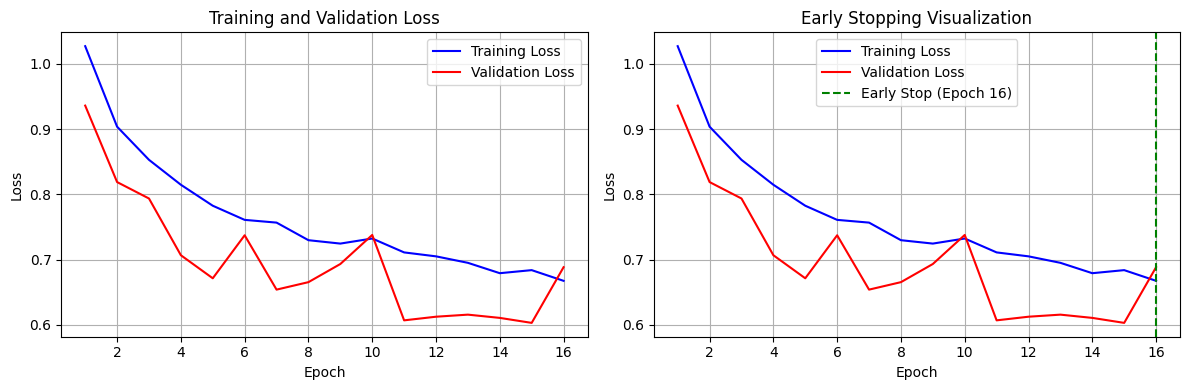


Training completed successfully!
Best validation loss: 0.60291
Model saved at: /content/drive/MyDrive/project/models/best_model.pt


In [52]:
# training curve visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.axvline(x=len(train_losses), color='g', linestyle='--', label=f'Early Stop (Epoch {len(train_losses)})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Early Stopping Visualization')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nTraining completed successfully!")
print(f"Best validation loss: {best_val_loss:.5f}")
print(f"Model saved at: {best_model_path}")

In [53]:
# Test Set Evaluation
def calculate_metrics(pred_masks, true_masks, threshold=0.5):
    pred_binary = (pred_masks > threshold).astype(int)
    true_binary = true_masks.astype(int)

    # Flatten all pixels
    pred_flat = pred_binary.flatten()
    true_flat = true_binary.flatten()

    # Calculate metrics
    iou = jaccard_score(true_flat, pred_flat, zero_division=0)
    dice = f1_score(true_flat, pred_flat, zero_division=0)
    accuracy = accuracy_score(true_flat, pred_flat)
    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)

    return {
        'IoU': iou,
        'Dice': dice,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

print("=" * 50)
print("Test Set Evaluation Results (Using Best Model)")
print("=" * 50)

# best model
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_pred_masks = []
all_true_masks = []

print("Running inference on test set...")
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing with best model"):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)

        # logits
        logits = model(images)
        pred_probs = torch.sigmoid(logits)

        all_pred_masks.append(pred_probs.cpu().numpy())
        all_true_masks.append(masks.cpu().numpy())

# Concatenate all predictions
all_pred_masks = np.concatenate(all_pred_masks, axis=0)
all_true_masks = np.concatenate(all_true_masks, axis=0)

# Calculate metrics
metrics = calculate_metrics(all_pred_masks, all_true_masks)

print("Test Set Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion matrix
pred_binary = (all_pred_masks > 0.5).astype(int).flatten()
true_binary = all_true_masks.astype(int).flatten()
cm = confusion_matrix(true_binary, pred_binary)

print(f"\nConfusion Matrix:")
print(f"[[TN={cm[0,0]}, FP={cm[0,1]}],")
print(f" [FN={cm[1,0]}, TP={cm[1,1]}]]")

total_pixels = len(true_binary)
water_pixels = np.sum(true_binary)
background_pixels = total_pixels - water_pixels

print(f"\nDataset Statistics:")
print(f"Total pixels: {total_pixels:,}")
print(f"Water pixels: {water_pixels:,} ({water_pixels/total_pixels*100:.1f}%)")
print(f"Background pixels: {background_pixels:,} ({background_pixels/total_pixels*100:.1f}%)")

Test Set Evaluation Results (Using Best Model)
Running inference on test set...


Testing with best model: 100%|██████████| 27/27 [00:04<00:00,  6.46it/s]


Test Set Performance Metrics:
IoU: 0.6248
Dice: 0.7690
Accuracy: 0.8752
Precision: 0.7844
Recall: 0.7543

Confusion Matrix:
[[TN=18674475, FP=1598991],
 [FN=1894347, TP=5816059]]

Dataset Statistics:
Total pixels: 27,983,872
Water pixels: 7,710,406 (27.6%)
Background pixels: 20,273,466 (72.4%)


In [58]:
# Gradient-based Attribution Analysis
import numpy as np
import matplotlib.pyplot as plt
import torch

def gradient_analysis(model, test_dataset, device):
    """Simple gradient-based attribution analysis"""
    print("Running Gradient Attribution Analysis...")

    model.eval()

    # Get test sample
    img, mask = test_dataset[0]

    # Calculate gradients
    img_tensor = img.unsqueeze(0).to(device).requires_grad_(True)

    with torch.enable_grad():
        output = model(img_tensor)
        score = torch.sigmoid(output).sum()
        score.backward()

        gradients = torch.abs(img_tensor.grad).cpu().numpy()[0]

    # Visualize results
    visualize_attribution(img.numpy(), gradients, mask.numpy())

def visualize_attribution(original_image, gradients, true_mask):
    """Visualize gradient attribution results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # First row
    axes[0, 0].imshow(np.transpose(original_image, (1, 2, 0)))
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(np.squeeze(true_mask), cmap='Blues')
    axes[0, 1].set_title("True Water Mask")
    axes[0, 1].axis('off')

    # Model prediction
    with torch.no_grad():
        img_tensor = torch.tensor(original_image, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0, 0]

    axes[0, 2].imshow(pred, cmap='Blues')
    axes[0, 2].set_title("Model Prediction")
    axes[0, 2].axis('off')

    # Second row: Gradient attribution per channel
    channels = ['Red', 'Green', 'Blue']
    channel_importance = []

    for i, ch in enumerate(channels):
        ch_grad = gradients[i]
        axes[1, i].imshow(ch_grad, cmap='hot')
        axes[1, i].set_title(f"{ch} Channel Attribution")
        axes[1, i].axis('off')

        importance = np.mean(ch_grad)
        channel_importance.append(importance)
        print(f"{ch} channel importance: {importance:.6f}")

    plt.tight_layout()
    plt.show()

    # Bar chart
    plt.figure(figsize=(8, 4))
    bars = plt.bar(channels, channel_importance, color=['red', 'green', 'blue'], alpha=0.7)
    plt.title("Channel Importance for Water Detection")
    plt.ylabel("Gradient Attribution Score")

    for bar, imp in zip(bars, channel_importance):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(channel_importance)*0.01,
                f'{imp:.4f}', ha='center', va='bottom')

    plt.show()

Running Gradient Attribution Analysis...
Red channel importance: 10.595405
Green channel importance: 7.678644
Blue channel importance: 6.389988


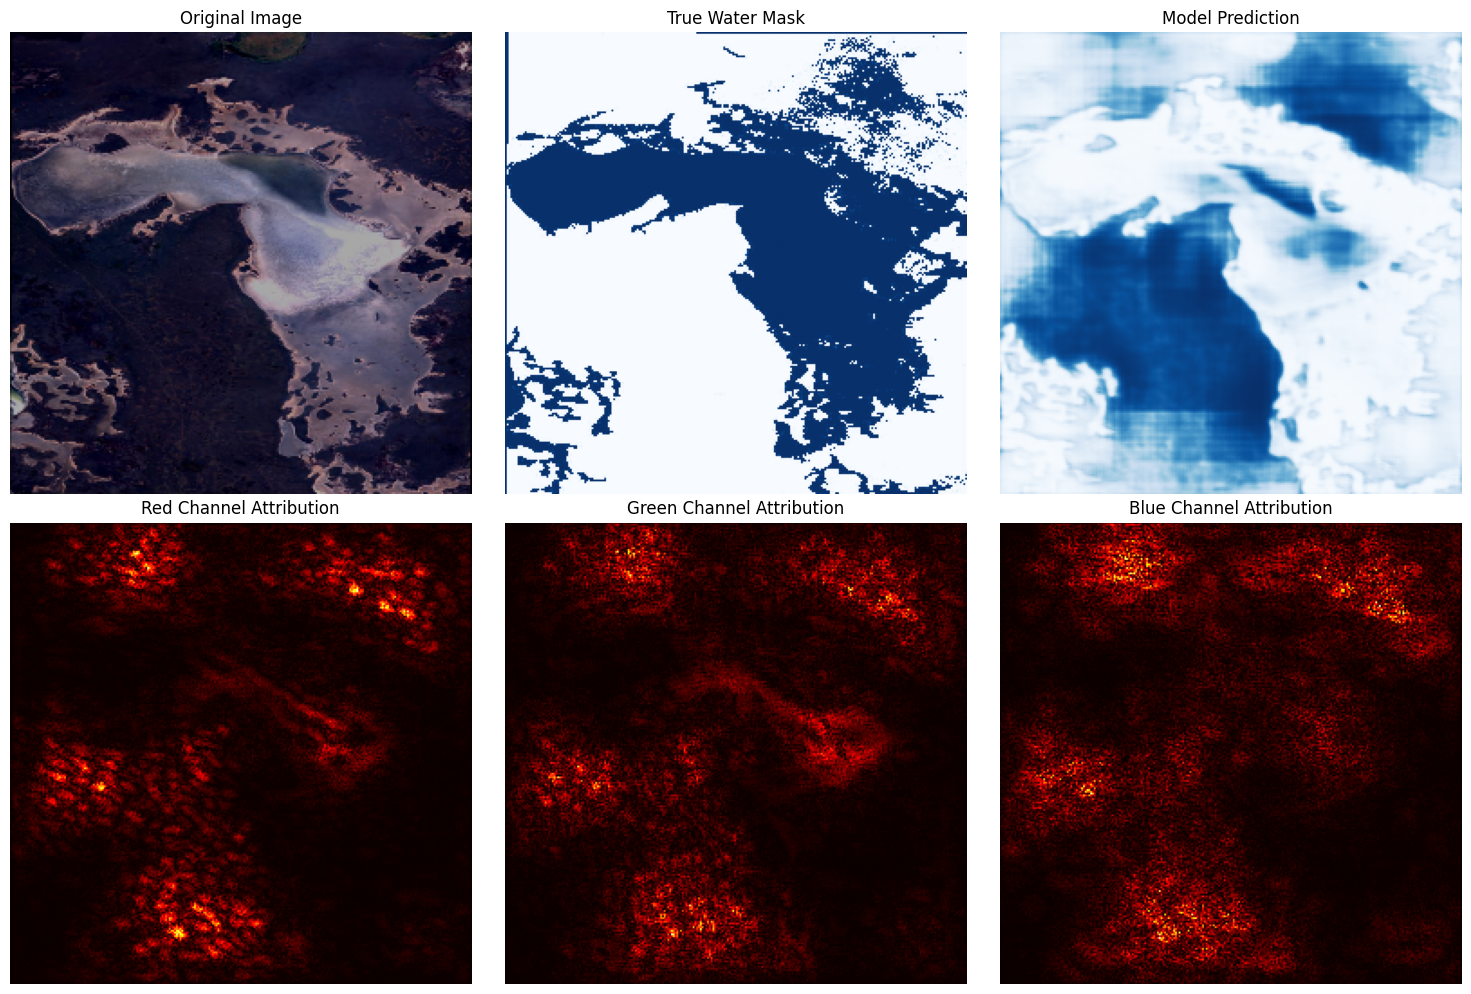

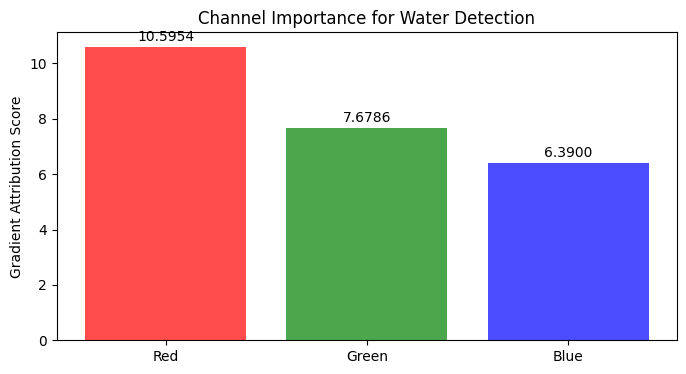

In [59]:
gradient_analysis(model, test_dataset, DEVICE)

Test Set Prediction Visualization:


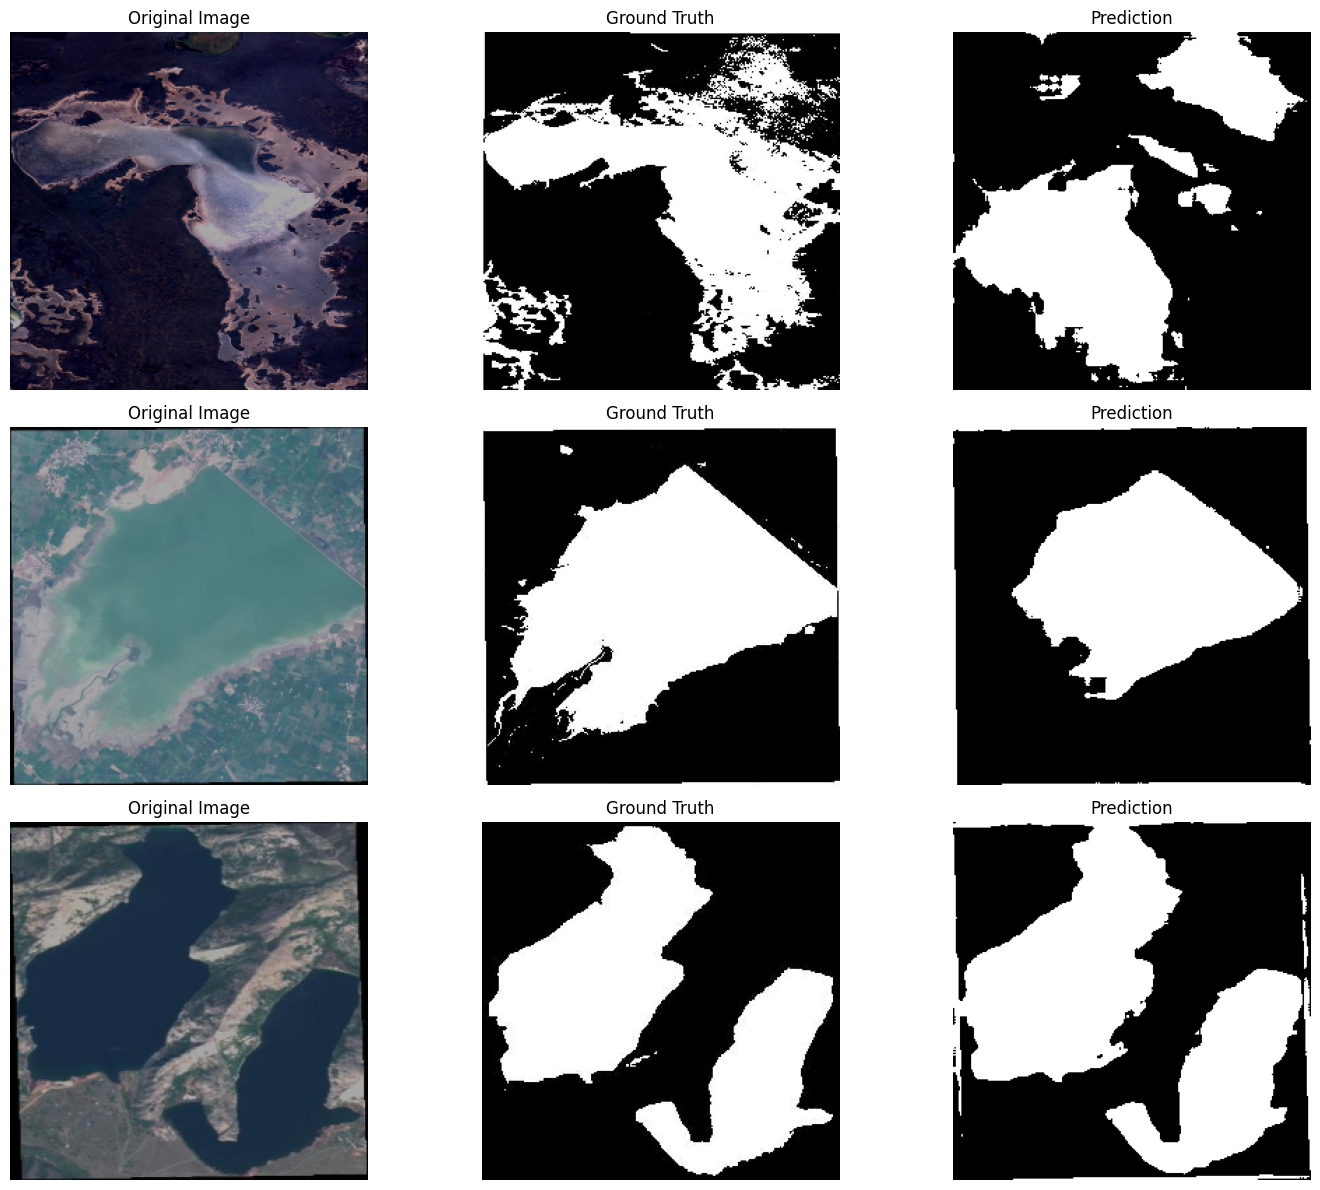

In [60]:
# Results Visualization
def visualize_results(dataset, model, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*4))

    with torch.no_grad():
        for i in range(num_samples):
            image, mask = dataset[i]
            image_input = image.unsqueeze(0).to(DEVICE)

            logits = model(image_input)
            pred_prob = torch.sigmoid(logits)
            pred_mask = (pred_prob > 0.5).float()

            # Convert to numpy for display
            image_np = np.transpose(image.numpy(), (1, 2, 0))
            mask_np = np.squeeze(mask.numpy())
            pred_np = np.squeeze(pred_mask.cpu().numpy())

            if num_samples == 1:
                axes[0].imshow(image_np)
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                axes[1].imshow(mask_np, cmap='gray')
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                axes[2].imshow(pred_np, cmap='gray')
                axes[2].set_title('Prediction')
                axes[2].axis('off')
            else:
                axes[i, 0].imshow(image_np)
                axes[i, 0].set_title('Original Image')
                axes[i, 0].axis('off')

                axes[i, 1].imshow(mask_np, cmap='gray')
                axes[i, 1].set_title('Ground Truth')
                axes[i, 1].axis('off')

                axes[i, 2].imshow(pred_np, cmap='gray')
                axes[i, 2].set_title('Prediction')
                axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("Test Set Prediction Visualization:")
visualize_results(test_dataset, model, num_samples=3)

In [61]:
# Environmental Impact Assessment - Updated Model Statistics
print("=" * 50)
print("Environmental Impact Assessment")
print("=" * 50)

# Recalculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = total_params * 4 / (1024 * 1024)

# Estimate training time
training_epochs = len(train_losses)

print(f"""
Model Architecture Analysis:
- Architecture: Custom CNN with U-Net decoder (Course-based)
- Total parameters: {total_params:,}
- Trainable parameters: {trainable_params:,}
- Model size: {model_size_mb:.1f} MB
- Actual training epochs: {training_epochs}

Performance Achievements:
- IoU Score: {metrics['IoU']:.3f}
- Dice Coefficient: {metrics['Dice']:.3f}
- Pixel Accuracy: {metrics['Accuracy']:.3f}
- Recall (Critical for disaster monitoring): {metrics['Recall']:.3f}

Computational Efficiency:
- Early stopping at epoch {training_epochs} (saved {EPOCHS - training_epochs} epochs)
- GPU acceleration: {'Yes' if DEVICE == 'cuda' else 'No'}
- Memory efficient architecture with skip connections

Environmental Benefits:
- Automated water body monitoring reduces manual interpretation time
- Supports rapid disaster response and flood assessment
- Enables continuous environmental monitoring
- Facilitates sustainable water resource management

Technical Innovation:
- Combined course CNN architecture with U-Net design principles
- Optimized data augmentation strategy
- Effective early stopping mechanism
- Multi-metric evaluation framework

Carbon Footprint Considerations:
- Efficient training with early stopping reduces energy consumption
- Lightweight model suitable for edge deployment
- Reusable trained model reduces future computational needs
""")

Environmental Impact Assessment

Model Architecture Analysis:
- Architecture: Custom CNN with U-Net decoder (Course-based)
- Total parameters: 3,869,857
- Trainable parameters: 3,869,857
- Model size: 14.8 MB
- Actual training epochs: 16

Performance Achievements:
- IoU Score: 0.625
- Dice Coefficient: 0.769
- Pixel Accuracy: 0.875
- Recall (Critical for disaster monitoring): 0.754

Computational Efficiency:
- Early stopping at epoch 16 (saved 24 epochs)
- GPU acceleration: Yes
- Memory efficient architecture with skip connections

Environmental Benefits:
- Automated water body monitoring reduces manual interpretation time
- Supports rapid disaster response and flood assessment
- Enables continuous environmental monitoring
- Facilitates sustainable water resource management

Technical Innovation:
- Combined course CNN architecture with U-Net design principles
- Optimized data augmentation strategy
- Effective early stopping mechanism
- Multi-metric evaluation framework

Carbon Footprin